<a href="https://colab.research.google.com/github/andreidore/aicrowd_blitz_may_2020/blob/master/foodc_t.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb tqdm

     |████████████████████████████████| 1.4MB 4.9MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 112kB 27.9MB/s 
     |████████████████████████████████| 460kB 34.5MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 71kB 12.5MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=ec3364ff57dc8a58afc2aa097518c4cf3fbf04ce3d57d9e22a0f7def765ec6b8
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.2-cp36-none-any.whl size=73605 sha256=decac11946b635bd4c558f16b1f922729ba069996fbdbfb409777654d1525b98
  Stored in directory: /root/.cache/pip/wheels/bc/ed/6c/028dea90d31b359cd2a7c8b0da4db80e41d24a59614154072e
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=

In [0]:
import itertools
import os
import shutil
from collections import Counter

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub


import pandas as pd

import wandb
from wandb.keras import WandbCallback

from tqdm import tqdm

In [4]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU :",tf.config.list_physical_devices('GPU'))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

TF version: 2.2.0
Hub version: 0.8.0
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Fri May 15 08:09:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+---------------------------------------------------------

In [0]:
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/train_images.zip
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/test_images.zip
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/train.csv
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/foodc/v0.1/test.csv

In [6]:
!mkdir data
!mkdir data/test
!mkdir data/train
!unzip train_images -d data/train
!unzip test_images -d data/test

Streaming output truncated to the last 5000 lines.
  inflating: data/train/train_images/145896eed0.jpg  
  inflating: data/train/train_images/c468193dfd.jpg  
  inflating: data/train/train_images/7c6dccda37.jpg  
  inflating: data/train/train_images/c03811cd27.jpg  
  inflating: data/train/train_images/f04e23613b.jpg  
  inflating: data/train/train_images/d1cbbc1134.jpg  
  inflating: data/train/train_images/d762ff4fd3.jpg  
  inflating: data/train/train_images/1df8826db5.jpg  
  inflating: data/train/train_images/4f05c60d04.jpg  
  inflating: data/train/train_images/1b33d95837.jpg  
  inflating: data/train/train_images/fa3e225fe7.jpg  
  inflating: data/train/train_images/7bcd015a19.jpg  
  inflating: data/train/train_images/a413778c2b.jpg  
  inflating: data/train/train_images/4945972217.jpg  
  inflating: data/train/train_images/5245cffff8.jpg  
  inflating: data/train/train_images/6012b508f4.jpg  
  inflating: data/train/train_images/8bf820b404.jpg  
  inflating: data/train/train_i

In [28]:

IMAGE_SIZE = (224, 224)
print("Input size {}".format(IMAGE_SIZE))

BATCH_SIZE = 32 

PREPROCESS_INPUT=tf.keras.applications.densenet.preprocess_input


Input size (224, 224)


In [29]:
classes=pd.read_csv('train.csv')
test_classes=pd.read_csv("test.csv")  
print(classes.head())
print(test_classes.head())
classes_list=[(x,y) for x, y in zip(classes["ImageId"],classes["ClassName"])]
print(classes_list[0:10])

          ImageId               ClassName
0  f27632d7e5.jpg                   water
1  efa87919ed.jpg  pizza-margherita-baked
2  4f169e8c8d.jpg                broccoli
3  a6956654bf.jpg  salad-leaf-salad-green
4  d99ce8c3bf.jpg                     egg
          ImageId
0  90e63a2fde.jpg
1  a554d1ca8d.jpg
2  48317e8ee8.jpg
3  79528df667.jpg
4  6d2f2f63f5.jpg
[('f27632d7e5.jpg', 'water'), ('efa87919ed.jpg', 'pizza-margherita-baked'), ('4f169e8c8d.jpg', 'broccoli'), ('a6956654bf.jpg', 'salad-leaf-salad-green'), ('d99ce8c3bf.jpg', 'egg'), ('0c2b1641a8.jpg', 'butter'), ('3f7e5ed3a9.jpg', 'bread-white'), ('ffcfba255c.jpg', 'butter'), ('b0687e0bfc.jpg', 'bread-white'), ('d6dc2e4278.jpg', 'bread-white')]


In [30]:
shutil.rmtree("images",ignore_errors=True)

os.makedirs("images",exist_ok=True)
for c in tqdm(classes["ClassName"].unique()):
  #print(c)
  os.makedirs(os.path.join("images",c))

for r in tqdm(classes_list):
  shutil.copyfile(os.path.join("data","train","train_images",r[0]),os.path.join("images",r[1],r[0]))

  

100%|██████████| 9323/9323 [00:02<00:00, 3557.06it/s]


In [32]:
! ls -l images/ | wc -l

62


In [11]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=PREPROCESS_INPUT,
        validation_split = 0.1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
)

train_generator = image_generator.flow_from_directory(
        "images",
        target_size = IMAGE_SIZE, 
        batch_size = BATCH_SIZE,
        subset = 'training', 
    )

validation_generator = image_generator.flow_from_directory(
        "images",
        target_size = IMAGE_SIZE, 
        batch_size = BATCH_SIZE,
        subset = 'validation'
    )

counter = Counter(train_generator.classes)       
print(counter)                   
print(len(counter))
print(list(counter.keys()))
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    

print(class_weights)

Found 8421 images belonging to 61 classes.
Found 902 images belonging to 61 classes.
Counter({55: 777, 9: 536, 44: 482, 11: 359, 18: 340, 53: 323, 13: 312, 14: 268, 43: 231, 58: 217, 36: 214, 23: 189, 24: 176, 1: 172, 3: 163, 51: 160, 35: 153, 30: 147, 42: 141, 59: 136, 15: 124, 17: 123, 57: 110, 28: 101, 41: 99, 54: 99, 21: 97, 16: 96, 39: 88, 60: 81, 2: 80, 22: 80, 31: 79, 49: 79, 56: 78, 6: 77, 12: 76, 50: 76, 34: 73, 4: 72, 20: 68, 25: 68, 10: 67, 26: 64, 0: 63, 32: 63, 52: 63, 5: 62, 38: 62, 27: 60, 29: 59, 8: 57, 7: 55, 47: 55, 46: 46, 45: 45, 48: 44, 33: 39, 37: 37, 19: 34, 40: 26})
61
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
{0: 12.333333333333334, 1: 4.517441860465116, 2: 9.7125, 3: 4.766871165644171, 4: 10.791666666666666, 5: 12.53225806451613, 6: 10.090909090909092, 7: 14.127272727272

In [33]:
base_model = tf.keras.applications.DenseNet201(weights = "imagenet", include_top=False, input_shape = IMAGE_SIZE+(3,))
base_model.trainable = False
base_model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________

In [36]:
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

weight_decay=1e-4 

x=tf.keras.layers.Dense(1024, activation='relu' , kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dropout(0.4)(x)

x=tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dropout(0.4)(x)

x= tf.keras.layers.Dense(train_generator.num_classes, activation='softmax', name='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [37]:
wandb.init(name='densenet-1', project="foodc")

W&B Run: https://app.wandb.ai/andrei-dore/foodc/runs/2f77o1y4

In [0]:
#optimizer = tf.keras.optimizers.Adam(lr=0.001,decay=1e-6)
optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

In [39]:
# compile the model


lrr= tf.keras.callbacks.ReduceLROnPlateau(
                      monitor='val_loss', #Metric to be measured
                       factor=.3, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-7) #The minimum learning rate 

model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath="best_model.hdf5",verbose=1,save_best_only=True)
wand_callback=wandb.keras.WandbCallback()
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=2,patience=7)

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size
history = model.fit(
    train_generator,
    epochs=50, steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint,wand_callback,lrr,early_stop_callback],class_weight=class_weights
    )

Epoch 1/50
263/263 [==============================] - ETA: 0s - loss: 22.5741 - accuracy: 0.1546
Epoch 00001: val_loss improved from inf to 2.62056, saving model to best_model.hdf5
263/263 [==============================] - 159s 606ms/step - loss: 22.5741 - accuracy: 0.1546 - val_loss: 2.6206 - val_accuracy: 0.3586 - lr: 1.0000e-04
Epoch 2/50
263/263 [==============================] - ETA: 0s - loss: 15.9348 - accuracy: 0.3158
Epoch 00002: val_loss improved from 2.62056 to 2.26148, saving model to best_model.hdf5
263/263 [==============================] - 160s 608ms/step - loss: 15.9348 - accuracy: 0.3158 - val_loss: 2.2615 - val_accuracy: 0.4023 - lr: 1.0000e-04
Epoch 3/50
263/263 [==============================] - ETA: 0s - loss: 13.3905 - accuracy: 0.3805
Epoch 00003: val_loss improved from 2.26148 to 2.22507, saving model to best_model.hdf5
263/263 [==============================] - 160s 610ms/step - loss: 13.3905 - accuracy: 0.3805 - val_loss: 2.2251 - val_accuracy: 0.4310 - lr: 1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


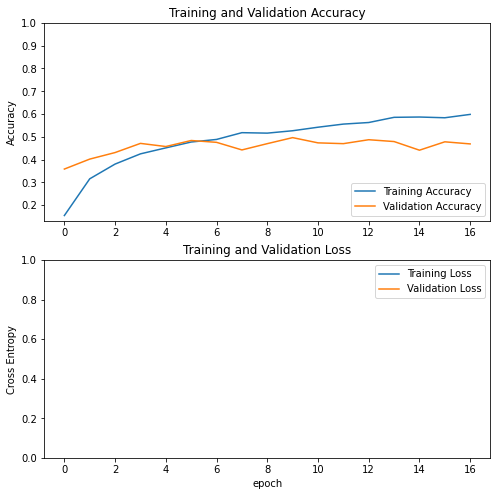

In [40]:
print(history.history.keys())

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
model.load_weights('best_model.hdf5')

In [0]:
base_model.trainable = True

In [43]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  707


In [0]:
# Fine-tune from this layer onwards
fine_tune_at = 600

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.00001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [47]:

lrr= tf.keras.callbacks.ReduceLROnPlateau(
                      monitor='val_loss', #Metric to be measured
                       factor=.3, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-7) #The minimum learning rate 

model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath="best_model.hdf5",verbose=1,save_best_only=True)
wand_callback=wandb.keras.WandbCallback()
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=2,patience=7)

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size
history_fine = model.fit(
    train_generator,
    initial_epoch =  history.epoch[-1],
    epochs=100, steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint,wand_callback,lrr,early_stop_callback],class_weight=class_weights
    )




Epoch 17/100
263/263 [==============================] - ETA: 0s - loss: 9.0677 - accuracy: 0.5070
Epoch 00017: val_loss improved from inf to 2.10800, saving model to best_model.hdf5
263/263 [==============================] - 165s 628ms/step - loss: 9.0677 - accuracy: 0.5070 - val_loss: 2.1080 - val_accuracy: 0.4563 - lr: 1.0000e-05
Epoch 18/100
263/263 [==============================] - ETA: 0s - loss: 8.6953 - accuracy: 0.5222
Epoch 00018: val_loss did not improve from 2.10800
263/263 [==============================] - 156s 594ms/step - loss: 8.6953 - accuracy: 0.5222 - val_loss: 2.1188 - val_accuracy: 0.4552 - lr: 1.0000e-05
Epoch 19/100
263/263 [==============================] - ETA: 0s - loss: 8.2997 - accuracy: 0.5327
Epoch 00019: val_loss did not improve from 2.10800
263/263 [==============================] - 157s 597ms/step - loss: 8.2997 - accuracy: 0.5327 - val_loss: 2.1425 - val_accuracy: 0.4621 - lr: 1.0000e-05
Epoch 20/100
263/263 [==============================] - ETA: 0s 

In [0]:
test_classes.head()

,ImageId
0,90e63a2fde.jpg
1,a554d1ca8d.jpg
2,48317e8ee8.jpg
3,79528df667.jpg
4,6d2f2f63f5.jpg


In [0]:
test_classes.iloc[0][0]

'90e63a2fde.jpg'

In [0]:
train_generator.class_indices

inv_classes = {v: k for k, v in train_generator.class_indices.items()}

print(inv_classes)

{0: 'almonds', 1: 'apple', 2: 'avocado', 3: 'banana', 4: 'beer', 5: 'biscuits', 6: 'boisson-au-glucose-50g', 7: 'bread-french-white-flour', 8: 'bread-sourdough', 9: 'bread-white', 10: 'bread-whole-wheat', 11: 'bread-wholemeal', 12: 'broccoli', 13: 'butter', 14: 'carrot', 15: 'cheese', 16: 'chicken', 17: 'chips-french-fries', 18: 'coffee-with-caffeine', 19: 'corn', 20: 'croissant', 21: 'cucumber', 22: 'dark-chocolate', 23: 'egg', 24: 'espresso-with-caffeine', 25: 'french-beans', 26: 'gruyere', 27: 'ham-raw', 28: 'hard-cheese', 29: 'honey', 30: 'jam', 31: 'leaf-spinach', 32: 'mandarine', 33: 'mayonnaise', 34: 'mixed-nuts', 35: 'mixed-salad-chopped-without-sauce', 36: 'mixed-vegetables', 37: 'onion', 38: 'parmesan', 39: 'pasta-spaghetti', 40: 'pickle', 41: 'pizza-margherita-baked', 42: 'potatoes-steamed', 43: 'rice', 44: 'salad-leaf-salad-green', 45: 'salami', 46: 'salmon', 47: 'sauce-savoury', 48: 'soft-cheese', 49: 'strawberries', 50: 'sweet-pepper', 51: 'tea', 52: 'tea-green', 53: 'tom

In [0]:
from tensorflow.keras.preprocessing import image
import numpy as np

img=image.load_img(os.path.join("data/test/test_images",test_classes.iloc[1][0]), target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = PREPROCESS_INPUT(x)
print(inv_classes[np.argmax(model.predict(x))])

water-mineral


In [0]:
result=[]

for i in tqdm(range(len(test_classes))):
  img=image.load_img(os.path.join("data/test/test_images",test_classes.iloc[i][0]), target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = PREPROCESS_INPUT(x)
  result.append(inv_classes[np.argmax(model.predict(x))])





100%|██████████| 484/484 [00:22<00:00, 21.35it/s]


In [0]:
result[0:10]

['water-mineral',
 'water-mineral',
 'tea-green',
 'hard-cheese',
 'bread-sourdough',
 'espresso-with-caffeine',
 'almonds',
 'bread-sourdough',
 'water',
 'espresso-with-caffeine']

In [0]:
df = pd.DataFrame(result,columns=['ClassName'])
df.to_csv('submission.csv',index=False)


In [0]:
from google.colab import files

files.download('submission.csv')